#Install lazypredict

In [ ]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.23.1

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 6.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.1 which is incompatible.


#Import libraries

In [ ]:
# Reloading necessary libraries
# import numpy and pandas
import pandas as pd
import numpy as np

# import for pre-processing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# import for visualization
import matplotlib.pyplot as plt

# import for model building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# import for Neural Network based model building
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


#import lazyClassifire
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


#Reading and splitting data

In [ ]:
# Building State specific model | State 'CA'

processed_data = pd.read_csv(f'/content/drive/MyDrive/US-accident-data_CA').dropna()
cols = processed_data.select_dtypes(include='object').columns


In [ ]:
# Class Balancing | Using Up Sampling

# Separate majority and minority classes
df_s1 = processed_data[processed_data['Severity']==1]
df_s2 = processed_data[processed_data['Severity']==2]
df_s3 = processed_data[processed_data['Severity']==3]
df_s4 = processed_data[processed_data['Severity']==4]

count = max(df_s1.count()[0], df_s2.count()[0], df_s3.count()[0], df_s4.count()[0])

# Upsample minority class
df_s1 = resample(df_s1, replace=df_s1.count()[0]<count, n_samples=count, random_state=42)
df_s2 = resample(df_s2, replace=df_s2.count()[0]<count, n_samples=count, random_state=42)
df_s3 = resample(df_s3, replace=df_s3.count()[0]<count, n_samples=count, random_state=42)
df_s4 = resample(df_s4, replace=df_s4.count()[0]<count, n_samples=count, random_state=42)

# Combine majority class with upsampled minority class
processed_data = pd.concat([df_s1, df_s2, df_s3, df_s4])

# Display new class counts
processed_data.groupby(by='Severity')['Severity'].count()

Severity
1    721698
2    721698
3    721698
4    721698
Name: Severity, dtype: int64

In [ ]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886792 entries, 508269 to 735419
Data columns (total 35 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Temperature(F)     float64
 4   Humidity(%)        float64
 5   Pressure(in)       float64
 6   Visibility(mi)     float64
 7   Wind_Direction     object 
 8   Wind_Speed(mph)    float64
 9   Weather_Condition  object 
 10  Amenity            bool   
 11  Bump               bool   
 12  Crossing           bool   
 13  Give_Way           bool   
 14  Junction           bool   
 15  No_Exit            bool   
 16  Railway            bool   
 17  Roundabout         bool   
 18  Station            bool   
 19  Stop               bool   
 20  Traffic_Calming    bool   
 21  Traffic_Signal     bool   
 22  Sunrise_Sunset     object 
 23  Civil_Twilight     object 
 24  Year               int64  
 25  Month         

In [ ]:
# Set the target for the prediction
target='Severity'

# set X and y
y = processed_data[target]
X = processed_data.drop(target, axis=1)

# Create the encoder.
encoder = OrdinalEncoder()
X[cols] = encoder.fit_transform(X[cols])

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the data set into training and validation data sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

# Scalling the features of Train Dataset, Validation Dataset and Test Dataset
scaler = StandardScaler()

# Scaling Train Dataset
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Scaling Validation Dataset
scaler = scaler.fit(X_val)
X_val = scaler.transform(X_val)

# Scaling Test Dataset
scaler = scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [ ]:
BBox = ((processed_data.Start_Lng.min(), processed_data.Start_Lng.max(), processed_data.Start_Lat.min(), processed_data.Start_Lat.max()))
BBox

(-124.374965, -114.227066, 32.542772, 42.00542)

NameError: ignored

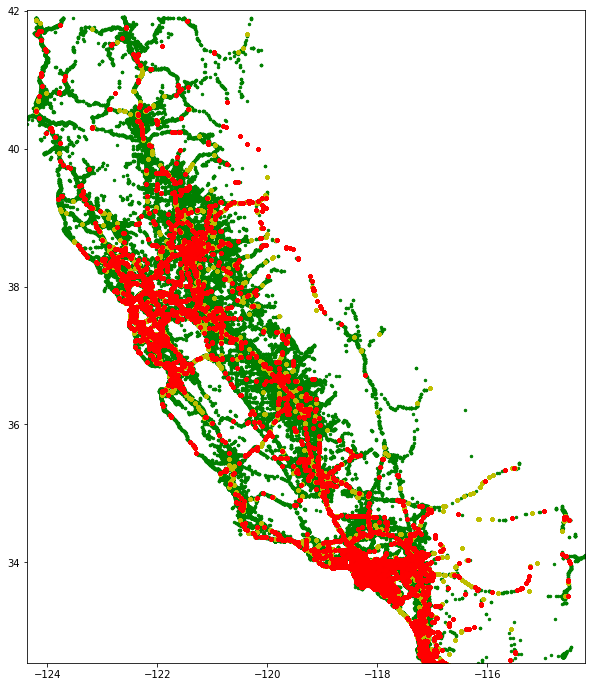

In [ ]:
fig, ax = plt.subplots(figsize = (10,12))
ax.scatter(processed_data[processed_data['Severity']==1].Start_Lng, processed_data[processed_data['Severity']==1].Start_Lat-.1, zorder=1, c='b', s=4)
ax.scatter(processed_data[processed_data['Severity']==2].Start_Lng, processed_data[processed_data['Severity']==2].Start_Lat-.1, zorder=1, c='g', s=6)
ax.scatter(processed_data[processed_data['Severity']==3].Start_Lng, processed_data[processed_data['Severity']==3].Start_Lat-.1, zorder=1, c='y', s=8)
ax.scatter(processed_data[processed_data['Severity']==4].Start_Lng, processed_data[processed_data['Severity']==4].Start_Lat-.1, zorder=1, c='r', s=10)

ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(map_pic, zorder=0, extent = BBox, aspect= 'auto', interpolation='none')
ax.imshow(map_pic, zorder=2, alpha= 0.5, extent = BBox, aspect= 'auto', interpolation='lanczos')

#Classification

##Decision tree

In [ ]:
# Decision Tree Algorithm | First Iteration

# Instantiate a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train & Test
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)

# Print accuracy_entropy
print('Decision Tree accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

Decision Tree accuracy_score: 0.914.


In [ ]:
# Decision Tree Algorithm | Optimization

# Create the parameter grid based on the results of random search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [12, 14, 16],
    'min_samples_split': [1000, 2000, 3000],
    'min_samples_leaf': [500, 1000, 1500]
}

# Instantiate the grid search model
grid_search = GridSearchCV(cv=3, estimator = clf, param_grid = param_grid, scoring='balanced_accuracy', n_jobs = -1,verbose = 5)

# Fit the grid search to the Validation Dataset
grid_search.fit(X_val, y_val)

# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
We can get accuracy of 0.8579872325619022 using {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 500, 'min_samples_split': 1000}


In [ ]:
result = {}
# Decision Tree Algorithm | Final Evaluation

# Instantiate a Decision Tree Classifier with Best Parameters
clf = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)

# Train & Test
clf.fit(X_train, y_train)
y_train_pred= clf.predict(X_train)
y_test_pred= clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
# Detailed report of classification done by model

train_accuracy, test_accuracy = accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))
print(f'Accuracy for the train dataset {train_accuracy:.1%}')
print(f'Accuracy for the test dataset {test_accuracy:.1%}')

# Highlighting the significance of each of the factors in the model
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
print("\nImportant features:\n", feature_imp.sort_values(ascending=False)[:10])

# stroring the accuracy score
result['Decision Tree'] = ['Train: '+str(round(train_accuracy*100, 1))+', Test: '+str(round(test_accuracy*100,1))]

              precision    recall  f1-score   support

           1       0.87      0.98      0.92    216510
           2       0.90      0.78      0.84    216509
           3       0.78      0.87      0.82    216510
           4       0.91      0.81      0.86    216509

    accuracy                           0.86    866038
   macro avg       0.86      0.86      0.86    866038
weighted avg       0.86      0.86      0.86    866038

Accuracy for the train dataset 87.1%
Accuracy for the test dataset 86.0%

Important features:
 Year            0.410834
Description     0.294151
Start_Lat       0.119882
Month           0.088335
Hour            0.016011
Street          0.011523
Start_Lng       0.009997
Day             0.007167
Pressure(in)    0.006618
City            0.006246
dtype: float64


##Naive bayes

In [ ]:
#Naive bayes GaussianNB algorithm
GNB = GaussianNB()
GNB.fit(X_train,y_train)
# Predict for test set
#
y_pred = GNB.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.63      0.00      0.00    216510
           2       0.25      0.99      0.40    216509
           3       0.29      0.00      0.00    216510
           4       0.50      0.03      0.05    216509

    accuracy                           0.25    866038
   macro avg       0.42      0.25      0.11    866038
weighted avg       0.42      0.25      0.11    866038



##SVM

In [ ]:
# Support Vector Machine | First Iteration

# Instantiate an object of class SVC()
clf = SVC(gamma='auto', kernel='rbf', random_state=42)

# Train & Test (limiting rows since SVM takes much time)
clf.fit(X_train[:10000], y_train[:10000])
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Support Vector Machine accuracy_score: {:.3f}.".format(accuracy_score(y_test, y_pred)))

Support Vector Machine accuracy_score: 0.680.


In [ ]:
# Support Vector Machine | Optimization

# Create the parameter grid based on the results of random search
param_grid = {
    'C': [0.1, 0.5, 1],
    'gamma': ['auto', 'scale']
}

# Instantiate the grid search model
grid_search = GridSearchCV(cv=5, estimator = clf, param_grid = param_grid, scoring='balanced_accuracy', n_jobs = -1,verbose = 5)

# Fit the grid search to the Validation Dataset
grid_search.fit(X_val[:5000], y_val[:5000])

# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
We can get accuracy of 0.6560155704017772 using {'C': 1, 'gamma': 'auto'}


In [ ]:
# Support Vector Machine | Final Evaluation

# Create a SVM Classifier
clf=SVC(**grid_search.best_params_, kernel='rbf', random_state=42)

# Train & Test
clf.fit(X_train[:20000], y_train[:20000])
y_train_pred= clf.predict(X_train[:20000])
y_test_pred= clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
# Detailed report of classification done by model

train_accuracy, test_accuracy = accuracy_score(y_train[:20000], y_train_pred), accuracy_score(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))
print(f'Accuracy for the train dataset {train_accuracy:.1%}')
print(f'Accuracy for the test dataset {test_accuracy:.1%}')

# stroring the accuracy score
result['Support Vector Machine'] = ['Train: '+str(round(train_accuracy*100, 1))+', Test: '+str(round(test_accuracy*100,1))]

              precision    recall  f1-score   support

           1       0.78      0.99      0.87    216510
           2       0.77      0.64      0.70    216509
           3       0.61      0.72      0.66    216510
           4       0.64      0.46      0.54    216509

    accuracy                           0.70    866038
   macro avg       0.70      0.70      0.69    866038
weighted avg       0.70      0.70      0.69    866038

Accuracy for the train dataset 73.9%
Accuracy for the test dataset 70.2%


#Simple MLP

In [ ]:
# Neural Network

model = Sequential()
model.add(Dense(128, input_dim=np.size(X_train,1), activation='relu'))
model.add(Dense(64, input_dim=np.size(X_train,1), activation='relu'))
model.add(Dense(5, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# build the model
history = model.fit(X_train, to_categorical(y_train.to_numpy()),
                    epochs=5, validation_data=(X_val, to_categorical(y_val.to_numpy())),
                    validation_steps=30, verbose=0)


loss, train_accuracy = model.evaluate(X_train, to_categorical(y_train.to_numpy()), verbose=0)
print(f"\nFor Training Dataset: Loss: {loss} and Accuracy: {train_accuracy}")

loss, test_accuracy = model.evaluate(X_test, to_categorical(y_test.to_numpy()), verbose=0)
print(f"\nFor Testing Dataset: Loss: {loss} and Accuracy: {test_accuracy}")

# stroring the accuracy score
result['Neural Network'] = ['Train: '+str(round(train_accuracy*100, 1))+', Test: '+str(round(test_accuracy*100,1))]




For Training Dataset: Loss: 0.30677369236946106 and Accuracy: 0.889572262763977

For Testing Dataset: Loss: 0.31486207246780396 and Accuracy: 0.8871042728424072


##Lazy Classifire

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train[:2000], X_test[:2000], y_train[:2000], y_test[:2000])

print(models)

100%|██████████| 29/29 [00:11<00:00,  2.49it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.83               0.83    None      0.82   
XGBClassifier                      0.81               0.82    None      0.81   
BaggingClassifier                  0.78               0.79    None      0.78   
RandomForestClassifier             0.77               0.77    None      0.76   
DecisionTreeClassifier             0.74               0.74    None      0.74   
ExtraTreesClassifier               0.71               0.71    None      0.70   
BernoulliNB                        0.63               0.63    None      0.61   
SVC                                0.62               0.62    None      0.60   
CalibratedClassifierCV             0.60               0.61    None      0.58   
LinearSVC                          0.60               0.61    None      0.58   
NuSVC                              0.60 